This is meant to demonstrate the basic functionality of fishlss 

In [1]:
# import all revelant packages
from headers import *
from fishlss import *

A fish2point object contains all the basic cosmological parameters. It's created using the following syntax: 

In [2]:
f2p = fish2point()

The default cosmological parameters are listed below:

In [3]:
f2p.params

{'output': 'mPk',
 'P_k_max_h/Mpc': 20.0,
 'z_pk': '0.0,10',
 'A_s': 2.090524323509276e-09,
 'n_s': 0.96824,
 'h': 0.677,
 'N_ur': 2.0328,
 'N_ncdm': 1,
 'm_ncdm': 0.06,
 'tau_reio': 0.0568,
 'omega_b': 0.022447,
 'omega_cdm': 0.11923}

Other assumptions that go into the calculation are listed below. I'm assuming the survey results are binned into one redshift bin cenetered at $z=1$. I'm treating the galaxy bias as a constant. These values are chosen somewhat arbitrarily and can be changed according to the experiment.

In [4]:
print('Number density of galaxies:',f2p.n,'Mpc^{-3}','\nSurvey volume:',f2p.Vsurvey,'Mpc^3','\nkhmin:',f2p.khmin,'hMpc^{-1}','\nkhmax',f2p.khmax,'hMpc^{-1}','\nLowest order galaxy bias b: 0.9','\nPower spectrum evaluated at z =',f2p.z)

Number density of galaxies: 12.0 Mpc^{-3} 
Survey volume: 13000000000.0 Mpc^3 
khmin: 0.0001 hMpc^{-1} 
khmax 1.0 hMpc^{-1} 
Lowest order galaxy bias b: 0.9 
Power spectrum evaluated at z = 1.0


The default parameters to marginalize over are $n_s$ and $h$.

In [5]:
list(f2p.marg_params)

['n_s', 'h']

Let's go ahead and marginalize over the the majority of our cosmological parameters.

In [6]:
f2p.marg_params = np.array(['A_s','n_s','h','N_ur','m_ncdm','tau_reio','omega_b','omega_cdm'])
list(f2p.marg_params)

['A_s', 'n_s', 'h', 'N_ur', 'm_ncdm', 'tau_reio', 'omega_b', 'omega_cdm']

fish2point objects automatically calculate the fidicual galaxy power spectrum at the redshift of the experiment. This includes the effects of RSD and redshift errors. For this experiment I'm assuming $\sigma_z/(1+z)\sim 0.01$. Below is a plot of the fidicual galaxy power spectrum $P_\text{obs}(k,\mu=0)$ at $z=1$

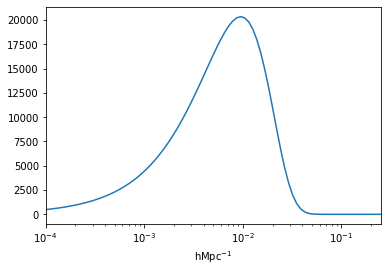

In [7]:
f2p.pretty_plot(f2p.k,f2p.P_fid)

We can also take derivatives the fidicual power spectrum with respect to any of the cosmological parameters.

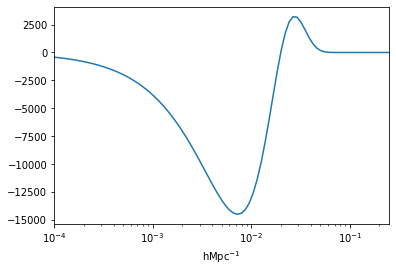

In [8]:
dPdh = f2p.compute_dPdp(param='h')
f2p.pretty_plot(f2p.k,dPdh)

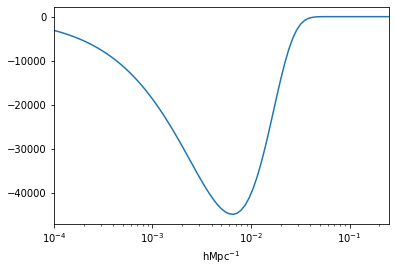

In [9]:
dPdns = f2p.compute_dPdp(param='n_s')
f2p.pretty_plot(f2p.k,dPdns)

We can also compute the covariance matrix. Below is a plot of the diagonal elements 

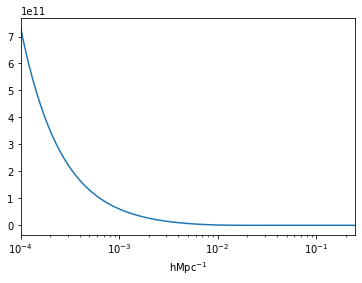

In [10]:
c = f2p.compute_covariance_matrix()
f2p.pretty_plot(f2p.k,np.diag(c))

The Fisher matrix can be computed using

In [11]:
F = f2p.compute_Fisher_matrix()

And the relative errors on the parameters that we chose to margenalize over can be found using

In [12]:
f2p.print_marginalized_errors(F=F)

Relative error on A_s: 0.045529713201644416
Relative error on n_s: 0.004714651192467096
Relative error on h: 0.021918983280980478
Relative error on N_ur: 0.10053447904958816
Relative error on m_ncdm: 2.691377193380027
Relative error on tau_reio: 19.058647756049062
Relative error on omega_b: 0.034845353375285174
Relative error on omega_cdm: 0.01064490353054228


It's easy to marginalize over a different set of parameters.

In [13]:
f2p.marg_params = np.array(['A_s','n_s','omega_b','omega_cdm'])
F = f2p.compute_Fisher_matrix()
f2p.print_marginalized_errors(F=F)

Relative error on A_s: 0.007542431580504847
Relative error on n_s: 0.0013637224761475736
Relative error on omega_b: 0.013449344806775601
Relative error on omega_cdm: 0.0024700564130046335
